# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy
import os
import glob
import pandas as pd
import math
plt.rcdefaults() #Setting default color of output plots
# For interactive plots
%matplotlib widget 
plt.rcParams.update({'figure.max_open_warning': 0})

# Paths

In [2]:
path_HED = "/Home/siv30/wad005/master/GRB/MATLAB/output/file_mat_TGF"
path_LED = "/Home/siv30/wad005/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF"

# Dict creation

In [3]:
#make a dictionary out of the manual trigger_ID list
triggers_data = pd.read_csv("trigger_ID.csv") #Manually created csv file that contains the GRB IDs, LED and HED filenames
GRB = triggers_data["GRB"].values
LED = triggers_data["LED"].values
HED = triggers_data["HED"].values
#Should be an easier way to sort the DF into an dict. Maybe transposing the DF
def create_triggers_dict():
    """
    trig_dict stores the GRB ID and LED/HED filenames.
    Key in dictionary is GRB id. Filenames are stored as tuple <LED,HED>
    return: trig_dict
    """
    trig_dict ={}
    
    try:
        if len(LED) & len(HED) != len(GRB):
            raise IndexError("Arrays not the same length. Check GRB,LED and HED")
        else:
            for i in np.arange(0,len(GRB)):
                GRB_name = GRB[i]
                LED_id = LED[i]
                HED_id = HED[i]
                trig_dict[GRB_name] = LED_id,HED_id
            return trig_dict
    except:
        raise

In [4]:
trig_dict= create_triggers_dict()
trig_dict

{'GRB 181222': (nan, '2018_12_22_20_11_36'),
 'GRB 190206': (nan, '2019_02_06_03_49_28'),
 'GRB 190305': (nan, '2019_03_05_13_05_19'),
 'GRB 190606': (nan, '2019_06_06_01_55_07'),
 'GRB 190807': (nan, '2018_08_07_02_19_37'),
 'GRB 200521': (nan, '2020_05_21_12_16_39'),
 'GRB 200716': (nan, '2020_07_16_22_57_40'),
 'GRB 201227': (nan, '2020_12_27_15_14_06')}

# Functions for handling matlab files

In [5]:
def read_matlab_file_with_BGO_data(matlabfilename):
    '''Read matlab file with ASIM BGO data from the high energy detector (HED)

    tus: relative times in microseconds.
    erg: energy channel (needs to be calibrated to keV using calibration coeff from https://git.app.uib.no/ASIM-MXGS/IN-FLIGHT_CALIBRATION_BGO/-/tree/master/CALIBRATION_COEFS )
    typ: normal, fast, valley, or overflow event
    adr: BGO address 1-12
    dau: dau address 1-4
    det: detector address 1-3
    DetCol: RGB color
    '''
    matlabfile_TGF = '/Home/siv30/wad005/master/GRB/MATLAB/output/file_mat_TGF/%s' % matlabfilename

    mat = scipy.io.loadmat(matlabfile_TGF)
    tus = mat['tus'].flatten()
    erg = mat['erg'].flatten()
    DetCol = mat['DetCol']
    adr = mat['adr'].flatten()
    dau = mat['dau'].flatten()
    det = mat['det'].flatten()
    typ = mat['typ'].flatten()
    return tus, erg, typ, adr, dau, det, DetCol


def read_matlab_file_with_CZT_data(filename):
    '''Read matlab file with ASIM CZT data from the low energy detector (LED)

    tus: relative time in microseconds (excluded multihits)
    erg: energy channel (excluded multihits)
    energy_keV: energy in keV (excluded multihits)
    tus_keep_multihit: relative time in microseconds (included multihits)
    erg_keep_multihit: energy channel (included multihits)
    multihit_indx: multihit index 0-4.o
    '''
    mat = scipy.io.loadmat("/Home/siv30/wad005/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF/%s.mat" % (filename))

    #keV_spectra = mat['keV_spectra_total_fulltrigger']

    # Included multihits. Important for light curves
    tus_keep_multihit = np.array(mat['tus_keep_multihit_fulltrigger'])[:,0] # relative time in microseconds
    erg_keep_multihit = np.array(mat['erg_keep_multihit_fulltrigger'])[0,:] # energy channel (unreliable for multi hits)
    multihit_indx = np.array(mat['multihit_fulltrigger'])[0,:] # multihit index. How many multihits in count. (0=1 count, 1=2 counts, 2=3 counts...)


    # The multihits are removed as they don't have a reliable energy estimate
    erg = np.array(mat['erg_fulltrigger'])[0,:] # energy channel of CZT pixel
    tus = np.array(mat['tus_fulltrigger'])[:,0] # relative time in microseconds
    energy_keV = np.array(mat['pixel_energy_fulltrigger']).flatten() # energy in keV of CZT pixel

    return tus, erg, energy_keV, tus_keep_multihit, erg_keep_multihit, multihit_indx

# Plotting functions

In [6]:
def plot_LED(LED_filename, output_dir,grb_id):
    plt.rcdefaults()
    tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED = read_matlab_file_with_CZT_data(
    LED_filename)

    fig0, (ax0, ax1) = plt.subplots(
        2, 1, figsize=(8, 8), sharex=True, sharey=False)
    ax0.set_title("LED")
    ax0.scatter(tus_LED, energy_keV_LED)
    ax0.set_xlabel("time [us]")
    ax0.set_ylabel("Energy [keV]")

    binsize = 10000  # us --> 10 ms bin
    ax1.hist(tus_LED, bins=np.arange(
        min(tus_LED), max(tus_LED)+binsize, binsize))
    ax1.set_xlabel("time [us]")
    ax1.set_ylabel("Counts per bin")

    plt.savefig(output_dir + "/{}_LED".format(grb_id))
    
def plot_HED(HED_filename, output_dir,grb_id):
    plt.rcdefaults()
    tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data(HED_filename)

    fig0, (ax0, ax1) = plt.subplots(
        2, 1, figsize=(8, 8), sharex=True, sharey=False)
    ax0.set_title("HED")

    ax0.scatter(tus_HED, erg_HED)
    ax0.set_xlabel("time [us]")
    ax0.set_ylabel("Energy channel")

    binsize = 10000  # us --> 10 ms bin
    ax1.hist(tus_HED, bins=np.arange(
        min(tus_HED), max(tus_HED)+binsize, binsize))
    ax1.set_xlabel("time [us]")
    ax1.set_ylabel("Counts per bin")
    
    output_dir_hed = output_dir + "/{}_HED".format(grb_id)
    print(output_dir_hed)
    plt.savefig(output_dir + "/{}_HED".format(grb_id)) #path where plot is saved



# main function

In [7]:
def main(grb_id):  # filename GRB ID
    # output array for tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED må modifiseres
    # Automake by making filename a list of filenames. Then the all the outout plots will be created

    # TODO:
    # write the find_filename_X function
    # filenames_LED_list = get_filenames(path_LED) #path is a global variable defined earlier
    # filenames_HED_list = get_filenames(path_HED) #path is a global variable defined earlier
#os.mkdir("/Users/andreas/phys/master/MATLAB/pyplots")
    trig_dict = create_triggers_dict()
    try:
        output_dir = os.mkdir("/Home/siv30/wad005/master/GRB/MATLAB/pyplots/{}".format(grb_id)) #Creating owd folder for grb_id
    except FileExistsError:
        output_dir = "/Home/siv30/wad005//master/GRB/MATLAB/pyplots/{}".format(grb_id) #selecting path if it already exists


    if type(grb_id) != str:
        raise TypeError("Input is not string")
    elif grb_id not in trig_dict:
        raise LookupError("grb_id not in dictionary")
    else:
        try:
            LED_filename = trig_dict[grb_id][0]
            HED_filename = trig_dict[grb_id][1]
            if type(LED_filename) == float and math.isnan(LED_filename):
                print("LED file not found. Plotting only HED")
                plot_HED(HED_filename,output_dir,grb_id)
                
            elif type(HED_filename) == float and math.isnan(HED_filename):
                print("HED file not found. Plotting only LED")
                plot_LED(LED_filename,output_dir,grb_id)
            else:
                plot_LED(LED_filename,output_dir,grb_id)
                plot_HED(HED_filename,output_dir,grb_id)
        except:
            print("Something went wrong")
    
    

In [8]:
main("GRB 190206")
#Still not saving the output plots

Something went wrong


# Plotting

In [17]:
def plot_HED(HED_filename,binsize=10000):
    tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data(HED_filename)

    fig0, ax1 = plt.subplots(
        1, 1, figsize=(12, 8), sharex=True, sharey=False)

    binsize = binsize  # us --> 10 ms bin
    ax1.hist(tus_HED, bins=np.arange(
        min(tus_HED), max(tus_HED) + binsize, binsize),edgecolor= "black", histtype="step")
    ax1.axhline(y=mean,color="red",label="mean of background")
    ax1.set_xlabel("time [us], binsize {} ms".format((binsize / 1000)))
    ax1.set_ylabel("Counts per bin")
    ax1.set_title("GRB " + HED_filename)
    ax1.legend()


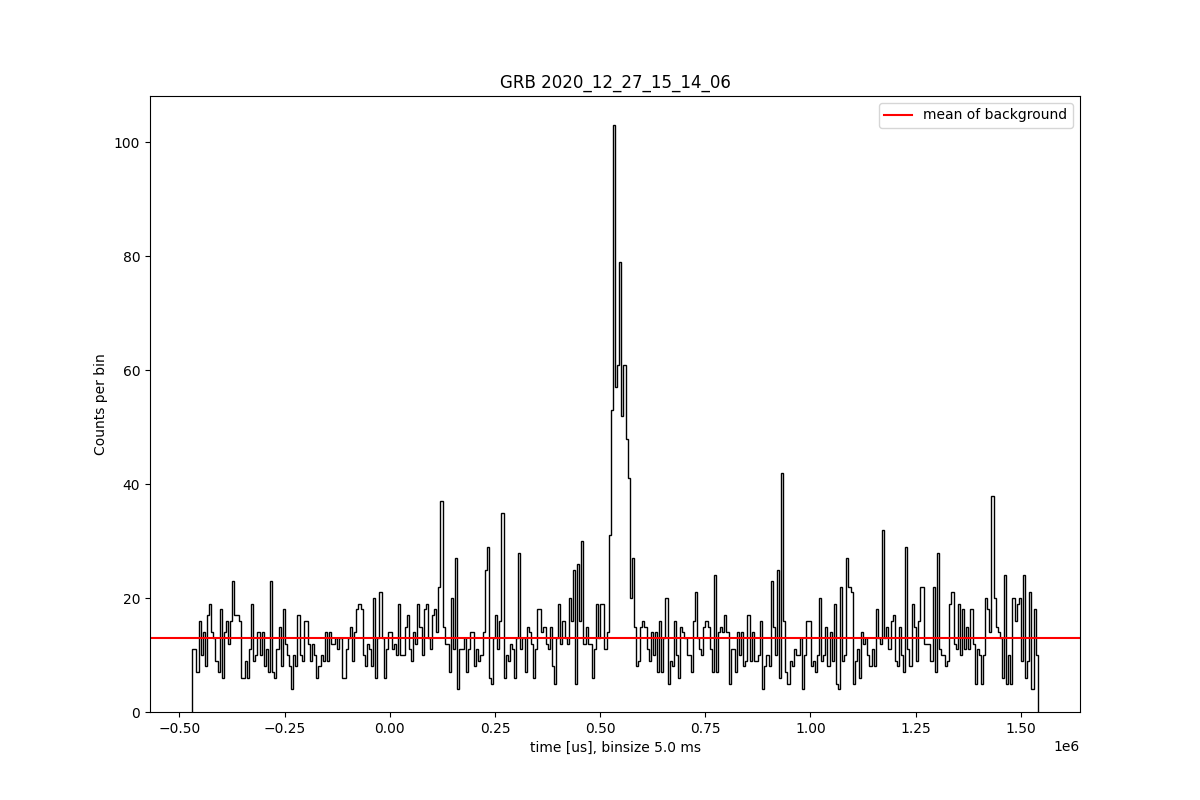

In [18]:

plot_HED(trig_dict['GRB 201227'][1],binsize=5000)

# Finding the background

Make a function of of the code below. 

In [12]:
tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data('2020_12_27_15_14_06')

In [13]:
binsize=5000
counts_in_bin = plt.hist(tus_HED, bins=np.arange(
        min(tus_HED), max(tus_HED) + binsize, binsize))[0]

In [14]:
counts_in_bin

array([ 11.,  11.,   7.,  16.,  10.,  14.,   8.,  17.,  19.,  14.,  13.,
         9.,   7.,  18.,   6.,  14.,  16.,  12.,  16.,  23.,  17.,  17.,
        16.,   6.,   6.,   9.,   6.,  11.,  19.,   9.,  10.,  14.,  10.,
        14.,   8.,  11.,   7.,  23.,   7.,   6.,  11.,  15.,   8.,  18.,
        12.,  10.,   8.,   4.,  10.,   8.,  17.,  10.,   9.,  16.,  16.,
        12.,   9.,  12.,  10.,   6.,   8.,  10.,   9.,  14.,   9.,  14.,
        12.,  12.,  13.,  11.,  13.,   6.,   6.,  11.,  13.,  15.,   9.,
        14.,  18.,  19.,  18.,  10.,   8.,  12.,  11.,   8.,  20.,   6.,
        13.,  21.,  13.,   6.,  11.,  14.,  14.,  11.,  12.,  10.,  19.,
        10.,  10.,  15.,  17.,  11.,   9.,  14.,  12.,  19.,  15.,  10.,
        18.,  19.,  13.,  11.,  17.,  18.,  14.,  22.,  37.,  15.,  12.,
        12.,   7.,  20.,  11.,  27.,   4.,  11.,  11.,  13.,   7.,  11.,
        14.,  14.,   8.,  11.,   9.,  10.,  14.,  25.,  29.,   6.,   5.,
        13.,  17.,  11.,  16.,  35.,   6.,  10.,   

In [15]:
background = np.append(counts_in_bin[:191],counts_in_bin[211:])

In [16]:
mean = np.mean(background)

In [ ]:
binsize=5000
bins=np.arange(min(tus_HED), max(tus_HED) + binsize, binsize)
digitized = np.digitize(tus_HED, bins)
bin_means = np.array([tus_HED[digitized == i].mean() for i in range(1, len(bins))])


In [ ]:
%matplotlib inline
from scipy.stats import binned_statistic

data = np.random.rand(100)
bin_means = binned_statistic(data, data, bins=10, range=(0, 1))[0]
bin_means
plt.plot(data)
plt.show()

# Graveyards

In [ ]:
# Not in use
def get_filenames(path):
    return sorted((f for f in os.listdir(path) if not f.startswith(".")), key=str.lower)